In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1269.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/623.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/820.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1354.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/45.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/369.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1711.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1173.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1488.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/436.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1409.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/71.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/1055.jpg
/kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign/215.jpg
/

## Importing required libraries

In [104]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from PIL import Image

## Loading dataset

In [112]:
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

dir_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
dir_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'
dir_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
dir_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'

#Loading images and converting them to numpy array using their RGB value
read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

### Loading Test Images

In [113]:
img_benign_test = [read(os.path.join(dir_benign_test, filename)) for filename in os.listdir(dir_benign_test)]
img_malignant_test = [read(os.path.join(dir_malignant_test, filename)) for filename in os.listdir(dir_malignant_test)]

### Loading Training images

In [114]:
img_benign_train = [read(os.path.join(dir_benign_train, filename)) for filename in os.listdir(dir_benign_train)]
img_malignant_train = [read(os.path.join(dir_malignant_train, filename)) for filename in os.listdir(dir_malignant_train)]

## Getting information of dataset

In [115]:
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/benign
There are 0 directories and 300 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/test/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train
There are 0 directories and 1440 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign
There are 0 directories and 1197 images in /kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant
There are 2 directories and 0 images in /kaggle/input/skin-cancer-malignant-vs-benign/test
There are 0 directories and 360 images in /kaggle/input/skin-cancer-malignant-vs-benign/tes

In [116]:
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

In [117]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [118]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]

def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths,'label': generate_labels(labels)})
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)


In [119]:
class CFG:
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    IMAGE_SIZE = (224, 224, 3)

<Axes: ylabel='label'>

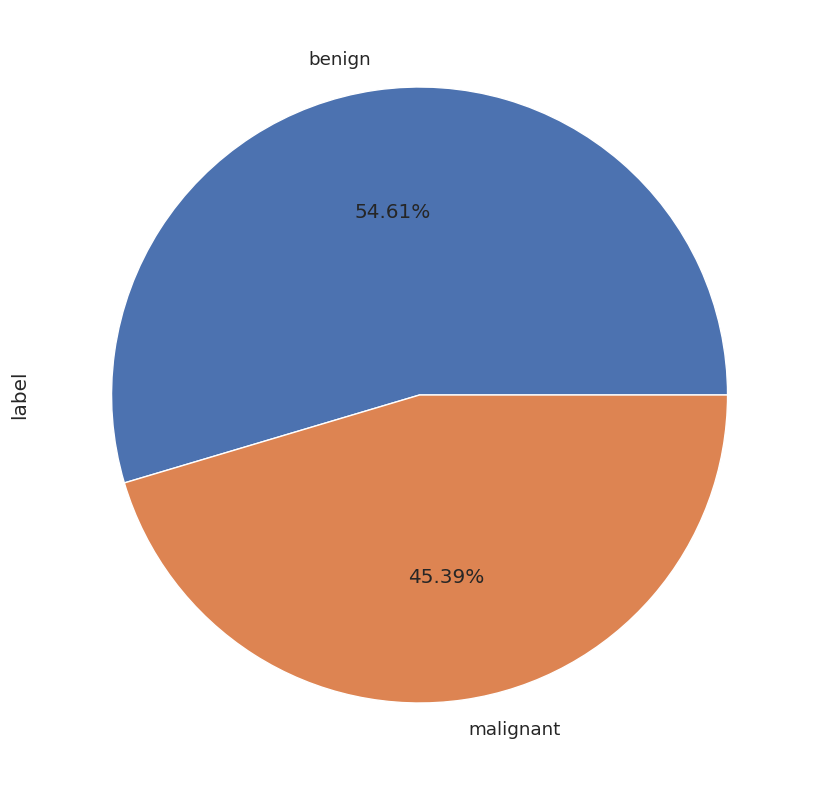

In [120]:
root_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/data/train/*/*.jpg"
images = glob.glob(root_dir)
df = pd.DataFrame({"filepath": images})
df["label"] = df["filepath"].str.split("/", expand=True)[6]
df["label"].value_counts().plot(kind="pie", autopct="%.2f%%",figsize=(10, 10))

In [121]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [122]:
train_df.tail(9)

,image_path,label,label_encoded
2628,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2629,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2630,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2631,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1


In [123]:
X_benign_train = np.array(img_benign_train)
X_malignant_train = np.array(img_malignant_train)

X_benign_test = np.array(img_benign_test)
X_malignant_test = np.array(img_malignant_test)

In [124]:
y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

y_malignant_train

array([1., 1., 1., ..., 1., 1., 1.])

In [125]:
X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0) 
y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


In [126]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

## View multiple random samples

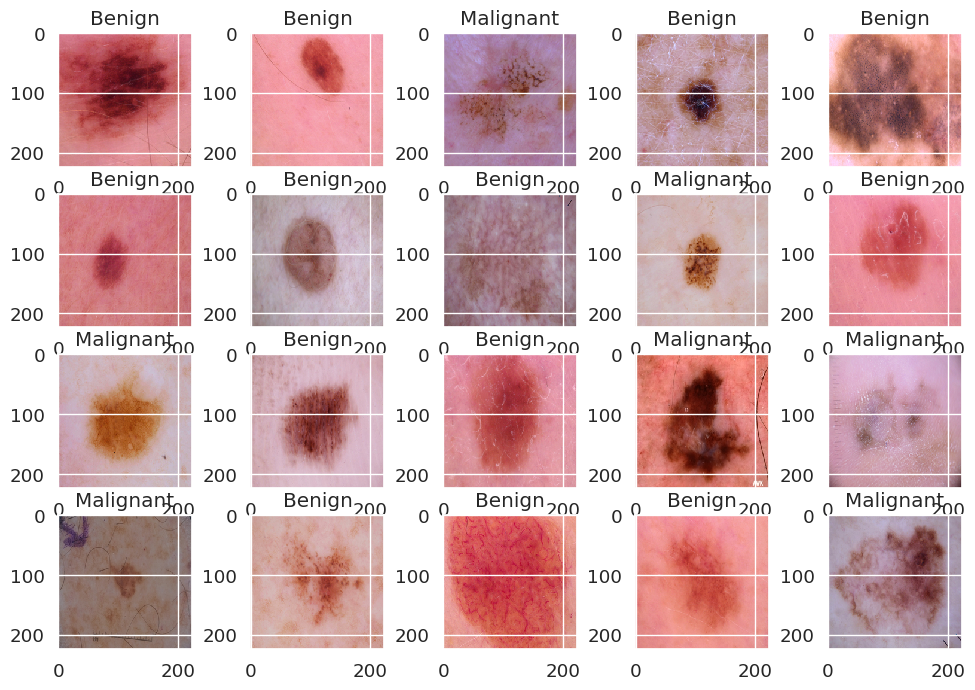

In [137]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [19]:
# # Select random sample from train_df
# idx = random.sample(train_df.index.to_list(), 1)[0]

# # Load the random sample and label
# sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# # View the random sample
# fig = plt.figure(figsize=(3,3))
# view_sample(sample_image, sample_label)

In [138]:
import keras
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [139]:
#Normalization
X_train = X_train/255
X_test = X_test/255

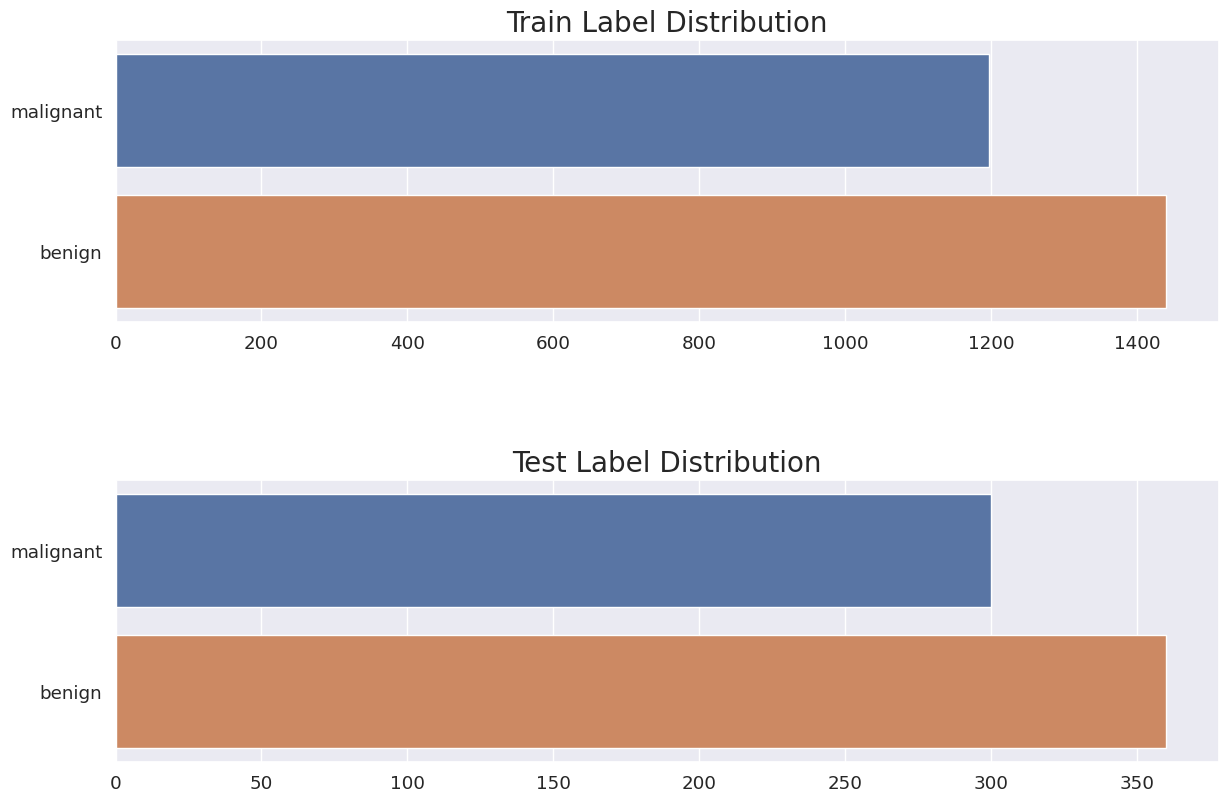

In [38]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
fig.tight_layout(pad=6.0)

ax1.set_title('Train Label Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,y=list(train_distribution.index),orient="h",ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Label Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,y=list(test_distribution.index),orient="h",ax=ax2)

plt.show()


## Building  CNN mode

In [143]:
def build_cnn_model(input_shape = (224, 224, 3), num_classes=2):
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.25)) 
    
    
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.summary()

    optimizer= Adam(lr=0.001) 
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    
    return model   

In [144]:
model_cnn = build_cnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 56, 56, 64)       

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [131]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 56, 56, 64)       

## Neural Network Diagram


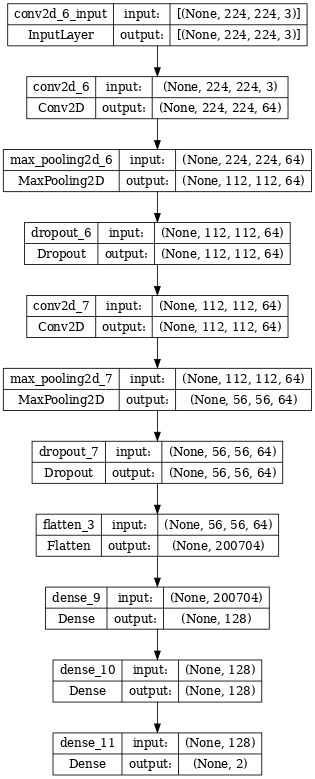

In [149]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [145]:
learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc',patience=5, verbose=1, factor=0.5, min_lr = 1e-7)
history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size = 64, verbose=1, callbacks=[learning_rate_annealer])
print(history.history.keys())

Epoch 1/10
33/33 [==============================] - 133s 4s/step - loss: 0.7845 - accuracy: 0.6577 - val_loss: 0.6044 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - 134s 4s/step - loss: 0.5021 - accuracy: 0.7435 - val_loss: 0.5427 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - 134s 4s/step - loss: 0.4692 - accuracy: 0.7558 - val_loss: 0.5274 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - 134s 4s/step - loss: 0.4265 - accuracy: 0.7809 - val_loss: 0.4234 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 5/10
33/33 [==============================] - 133s 4s/step - loss: 0.3756 - accuracy: 0.8004 - val_loss: 0.3938 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 6/10
33/33 [==============================] - 134s 4s/step - loss: 0.3563 - accuracy: 0.8179 - val_loss: 0.4062 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 7/10
33/33 [==============================] - 133s 4s/step - loss: 0.3

## Plot for Model Accuracy & Model Loss

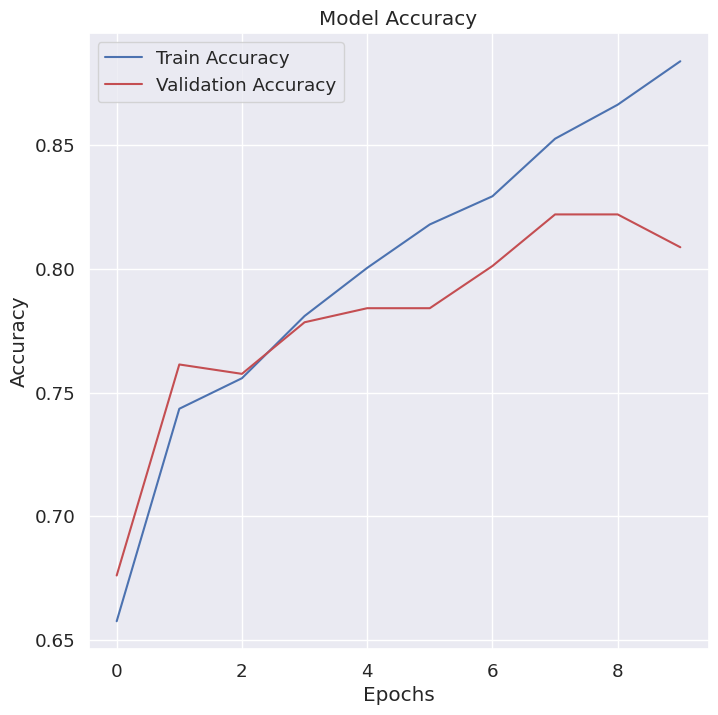

In [146]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['val_accuracy'], color = 'r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

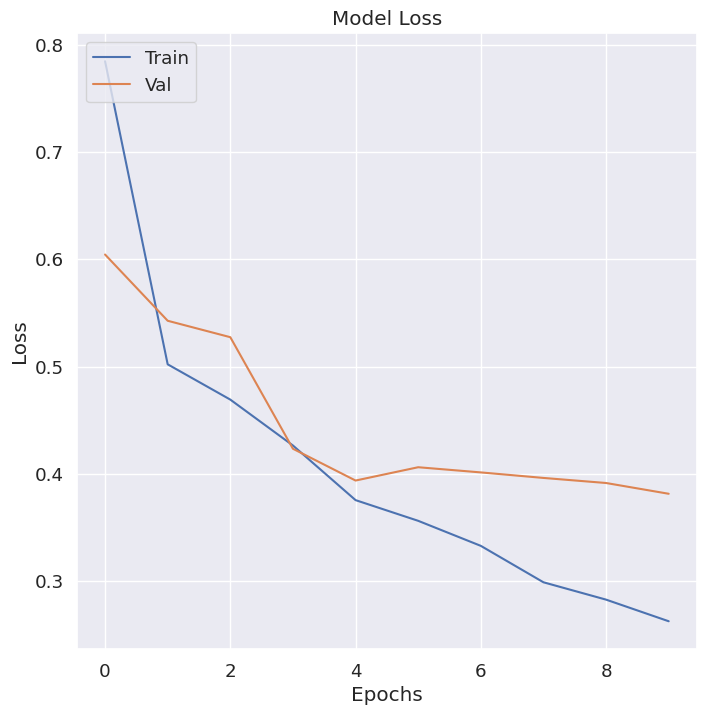

In [147]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Testing model on test data to evaluate / Evaluation of the model

In [151]:
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)
print("Accuracy : ",accuracy_score(np.argmax(y_test, axis=1),y_pred))

21/21 [==============================] - 9s 416ms/step
Accuracy :  0.8212121212121212


In [154]:
#confusion matrix
def labels_confusion_matrix(test_folder):
    
    folder_path=test_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) 
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


## Deployment of the model

1/1 [==============================] - 0s 84ms/step


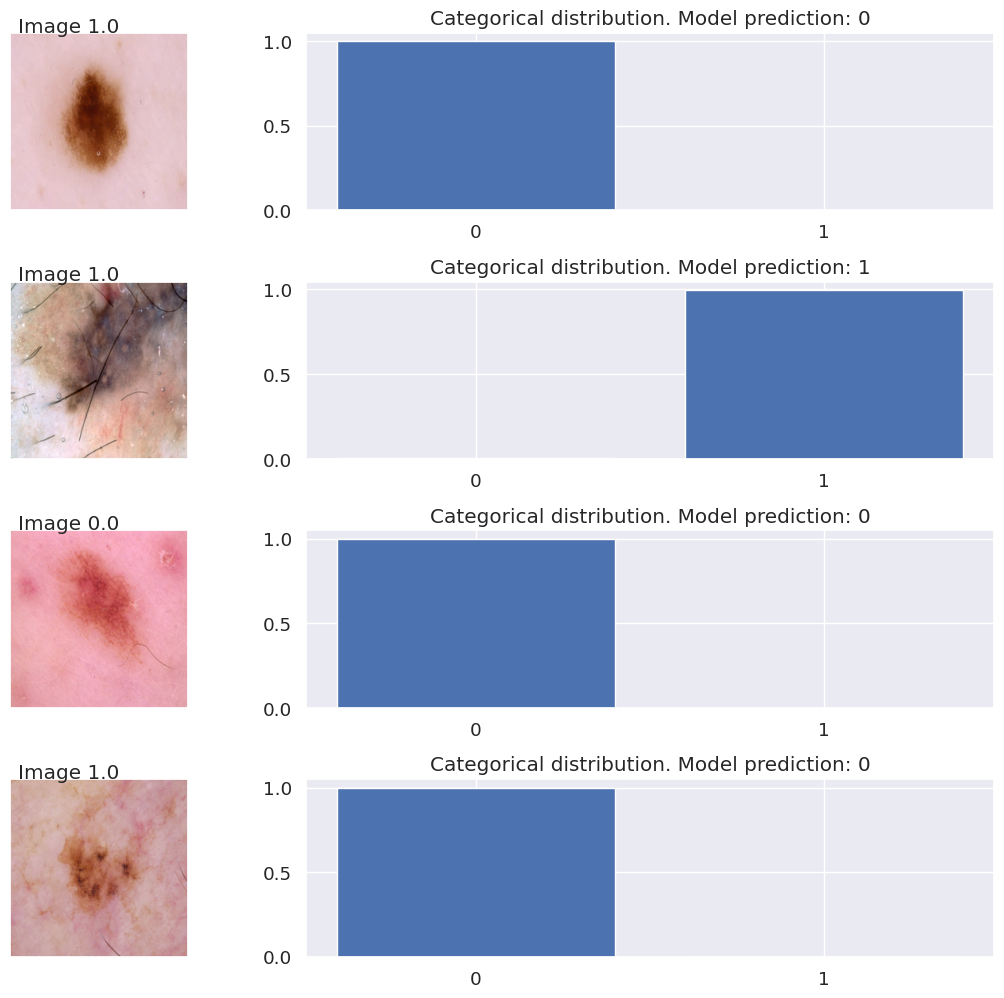

In [78]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images,4)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Image {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

## Check the prediction of the model

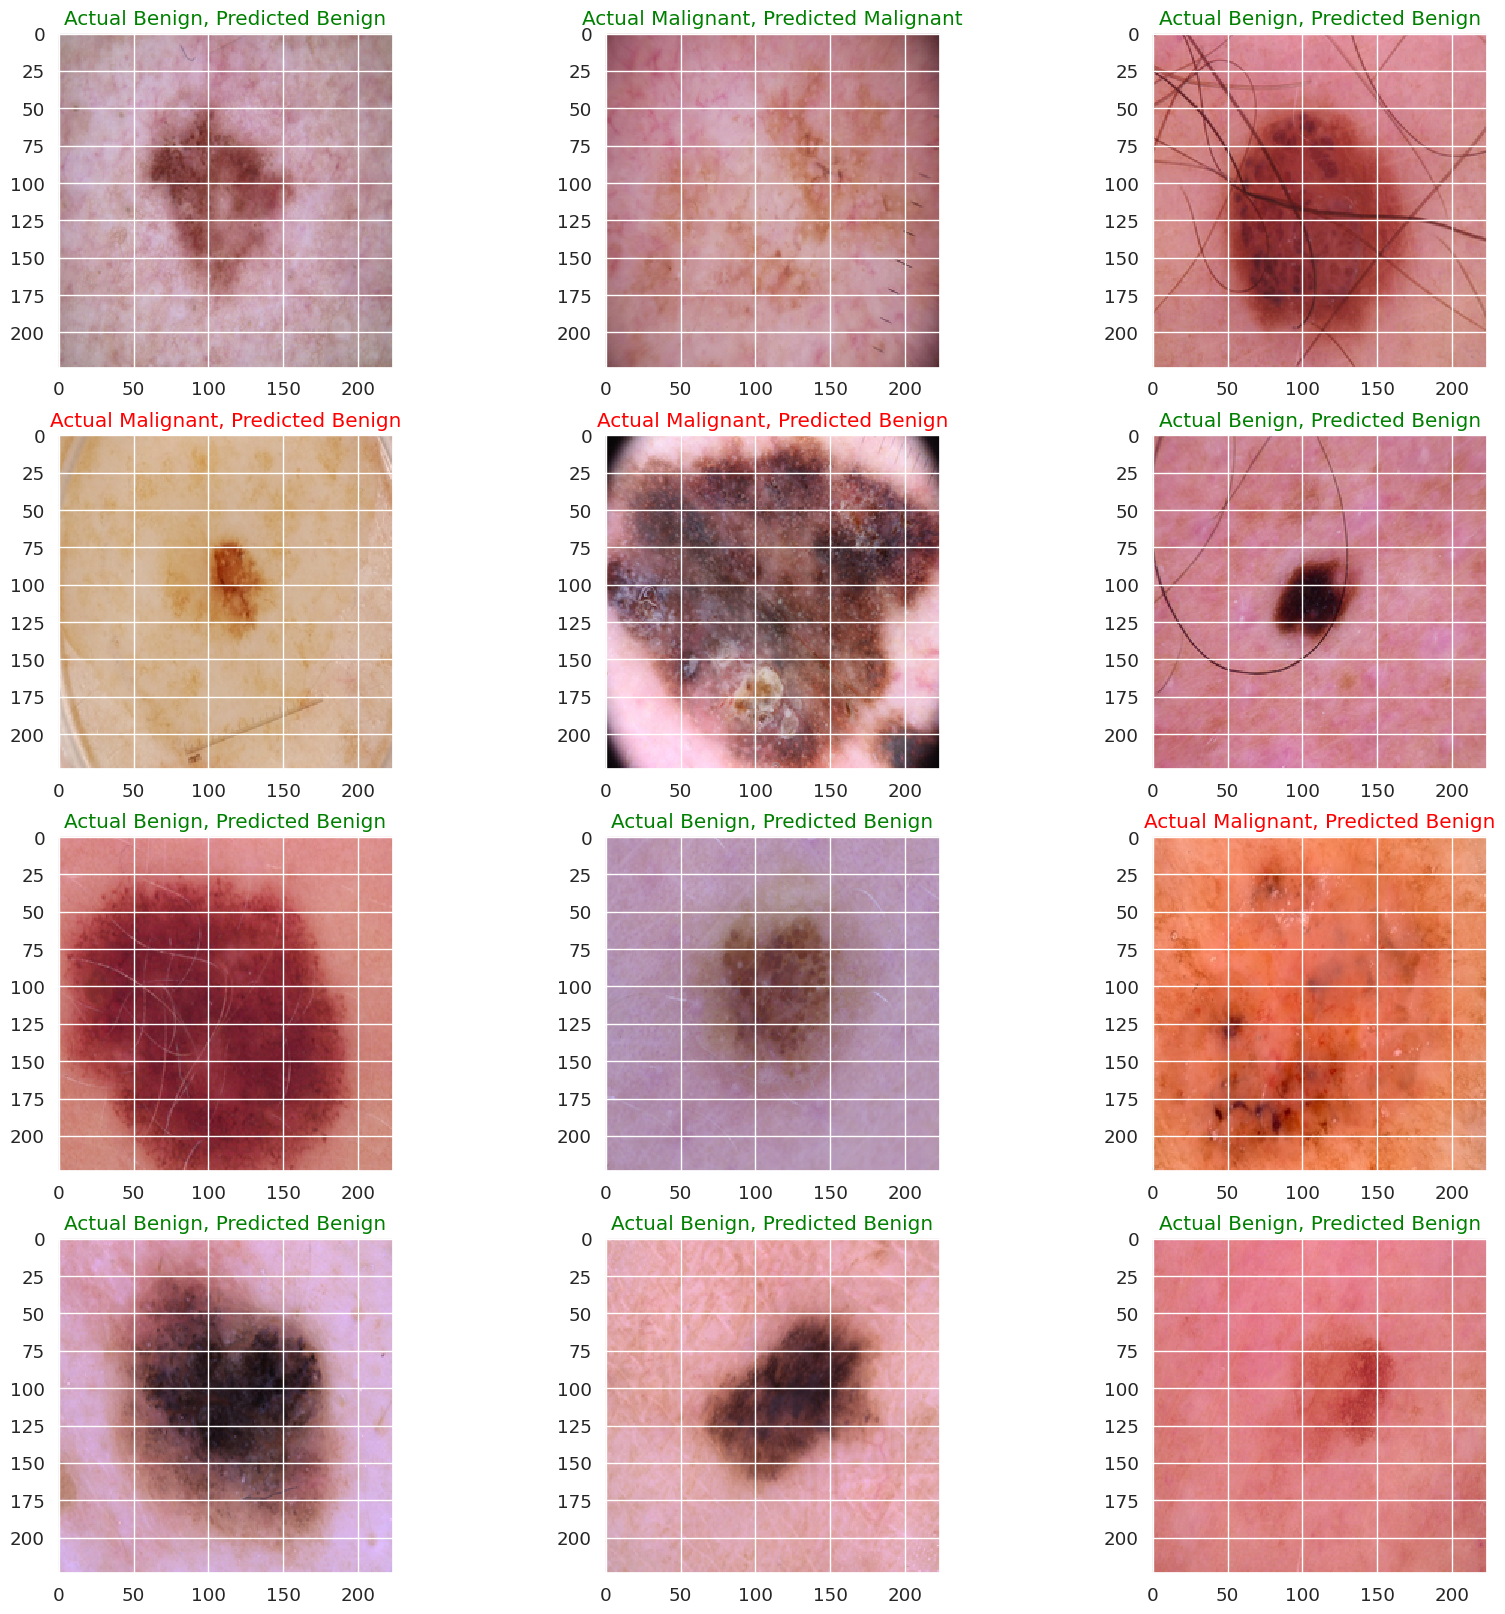

In [103]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# shuffling data
s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]
y_pred = y_pred[s2]

# plotting
fig = plt.figure(figsize=(20,20))
columns = 3
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_test[i] == 1:       
        if y_pred[i] == 1:
            ax.set_title('Actual Malignant, Predicted Malignant', color='green')
        else:
            ax.set_title('Actual Malignant, Predicted Benign', color='red')
    
    else:
        if y_pred[i] == 0:
            ax.set_title('Actual Benign, Predicted Benign', color='green')
        else:
            ax.set_title('Actual Benign, Predicted Malignant', color='yellow')

        
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()


## Saving the model

In [ ]:
from tensorflow.keras.models import save_model
save_model(model_cnn, '/kaggle/working/cnn_model.h5')